In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.

Transfer learning

1. Finetuning the convent - 랜덤 초기화 대신 pretrain 모델을 불러오는 것
2. ConvNet as fiexed feature extractor - pretrain 모델 부분을 고정

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

## hymenoptera_data




개미와 벌의 두 가지 클래스로 이루어진 데이터셋으로 각 클래스 별 120개의 훈련 데이터와 75개의 테스트 이미지로 구성

먼저 구글 드라이브에 마운트

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Dataset, dataloader 정의

datasets.ImageFolder 함수를 사용하려면 데이터셋이 다음과 같은 형식으로 구성되어야 함

dataset
- label 1
    - 0.jpg
    - 1.jpg
- label 2
    - 0.jpg
    - 1.jpg




In [5]:
# Data augmentation and normalization for training
# Just normalization for validation
## Normalize 부분의 mean, std 는 ImageNet 의 통계치
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/SKCNC/20210618/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
classes = image_datasets['train'].class_to_idx
print(classes, class_names)

{'ants': 0, 'bees': 1} ['ants', 'bees']


### Visualize a few images

iter는 반복가능한 객체에서 이터레이터를 반환하고 next를 통해서 하나씩 꺼냄

torch.Size([4, 3, 224, 224])


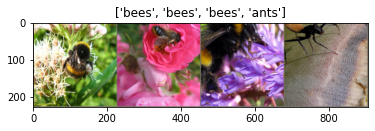

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
print(inputs.size())
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Device 정의

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 훈련코드 구성

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = -float('inf')

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        for param_group in optimizer.param_groups:
            print('Learning Rate {}'.format(param_group['lr']))
        print('-' * 10)        

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Visualize 코드 구성

In [21]:
def visualize_model(model, num_images=6):

    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=False)
                    return
        model.train(mode=False)

## ResNet-18 모델 불러오기

torchvision.models 모듈에 resnet18 존재

https://pytorch.org/vision/stable/models.html

모델을 불러올때 pretrain=True 로 하면 ImageNet 데이터셋에 대해 훈련시킨 모델 불러옴

### Scratch training

In [13]:
model_scratch = models.resnet18(pretrained=False)
for p, _ in model_scratch.named_parameters():
    print(p)

conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.weight
layer2.1.bn2.weight
layer2.1.bn2.bias
layer3.0.conv1.weight
layer3.0.bn1.weight
layer3.0.bn1.bias
layer3.0.conv2.weight
layer3.0.bn2.weight
layer3.0.bn2.bias
layer3.0.downsample.0.weight
layer3.0.downsample.1.weight
layer3.0.downsample.1.bias
layer3.1.conv1.weight
layer3.1.bn1.weight
layer3.1.bn1.bias
layer3.1.conv2.weight
layer3.1.bn2.weight
layer3.1.bn2.bias
layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.we

ImageNet 에 대한 모델이므로 마지막 fully-connected 의 차원은 1000

In [14]:
model_scratch.fc.out_features

1000

현재 가진 데이터셋의 클래스는 2이므로 이를 새로운 fc 로 바꿈

In [15]:
num_last_feats = model_scratch.fc.in_features
model_scratch.fc = nn.Linear(num_last_feats, len(class_names))
model_scratch.fc

Linear(in_features=512, out_features=2, bias=True)

훈련 준비

In [17]:
model_scratch = model_scratch.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model_scratch.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [18]:
_ = train_model(model_scratch, criterion, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
Learning Rate 0.001
----------
train Loss: 0.7232 Acc: 0.5533
val Loss: 0.6726 Acc: 0.6275

Epoch 1/24
Learning Rate 0.001
----------
train Loss: 0.7395 Acc: 0.5861
val Loss: 0.6462 Acc: 0.6209

Epoch 2/24
Learning Rate 0.001
----------
train Loss: 0.7796 Acc: 0.6393
val Loss: 0.6801 Acc: 0.7059

Epoch 3/24
Learning Rate 0.001
----------
train Loss: 0.7931 Acc: 0.5738
val Loss: 0.6705 Acc: 0.6863

Epoch 4/24
Learning Rate 0.001
----------
train Loss: 0.7519 Acc: 0.5861
val Loss: 0.5701 Acc: 0.6993

Epoch 5/24
Learning Rate 0.001
----------
train Loss: 0.8333 Acc: 0.5246
val Loss: 0.6781 Acc: 0.6536

Epoch 6/24
Learning Rate 0.001
----------
train Loss: 0.7226 Acc: 0.5820
val Loss: 0.7604 Acc: 0.6340

Epoch 7/24
Learning Rate 0.0001
----------
train Loss: 0.6138 Acc: 0.6639
val Loss: 0.6167 Acc: 0.7124

Epoch 8/24
Learning Rate 0.0001
----------
train Loss: 0.5931 Acc: 0.6639
val Loss: 0.5970 Acc: 0.6797

Epoch 9/24
Learning Rate 0.0001
----------
train Loss: 0.6007 Acc: 0.68

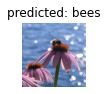

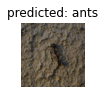

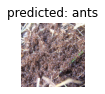

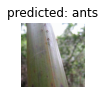

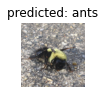

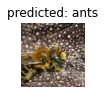

In [22]:
visualize_model(model_scratch)

### Fintuning the convnet

In [23]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [24]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
Learning Rate 0.001
----------
train Loss: 0.6032 Acc: 0.6967
val Loss: 0.2455 Acc: 0.9020

Epoch 1/24
Learning Rate 0.001
----------
train Loss: 0.4387 Acc: 0.8115
val Loss: 0.2735 Acc: 0.9020

Epoch 2/24
Learning Rate 0.001
----------
train Loss: 0.6006 Acc: 0.7746
val Loss: 0.2518 Acc: 0.9085

Epoch 3/24
Learning Rate 0.001
----------
train Loss: 0.5051 Acc: 0.7951
val Loss: 0.2798 Acc: 0.9150

Epoch 4/24
Learning Rate 0.001
----------
train Loss: 0.7438 Acc: 0.7336
val Loss: 0.8660 Acc: 0.7712

Epoch 5/24
Learning Rate 0.001
----------
train Loss: 0.5686 Acc: 0.7910
val Loss: 0.3710 Acc: 0.8693

Epoch 6/24
Learning Rate 0.001
----------
train Loss: 0.4622 Acc: 0.8074
val Loss: 0.2192 Acc: 0.8954

Epoch 7/24
Learning Rate 0.0001
----------
train Loss: 0.3234 Acc: 0.8525
val Loss: 0.2119 Acc: 0.9085

Epoch 8/24
Learning Rate 0.0001
----------
train Loss: 0.2987 Acc: 0.8607
val Loss: 0.2080 Acc: 0.9216

Epoch 9/24
Learning Rate 0.0001
----------
train Loss: 0.2892 Acc: 0.88

### ConvNet as fixed feature extractor

pretrain 모델의 파라미터는 고정시키고 마지막 fully-connected 만 트레이닝

In [25]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [26]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
Learning Rate 0.001
----------
train Loss: 0.5501 Acc: 0.7254
val Loss: 0.2669 Acc: 0.9020

Epoch 1/24
Learning Rate 0.001
----------
train Loss: 0.4507 Acc: 0.7951
val Loss: 0.2260 Acc: 0.9216

Epoch 2/24
Learning Rate 0.001
----------
train Loss: 0.7506 Acc: 0.7172
val Loss: 0.1701 Acc: 0.9542

Epoch 3/24
Learning Rate 0.001
----------
train Loss: 0.5653 Acc: 0.7705
val Loss: 0.2100 Acc: 0.9346

Epoch 4/24
Learning Rate 0.001
----------
train Loss: 0.4053 Acc: 0.8156
val Loss: 0.4954 Acc: 0.7974

Epoch 5/24
Learning Rate 0.001
----------
train Loss: 0.5054 Acc: 0.7992
val Loss: 0.2878 Acc: 0.9085

Epoch 6/24
Learning Rate 0.001
----------
train Loss: 0.4194 Acc: 0.8156
val Loss: 0.5254 Acc: 0.8170

Epoch 7/24
Learning Rate 0.0001
----------
train Loss: 0.3788 Acc: 0.8238
val Loss: 0.1697 Acc: 0.9608

Epoch 8/24
Learning Rate 0.0001
----------
train Loss: 0.3524 Acc: 0.8279
val Loss: 0.1879 Acc: 0.9412

Epoch 9/24
Learning Rate 0.0001
----------
train Loss: 0.3996 Acc: 0.82

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


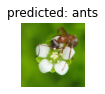

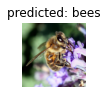

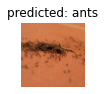

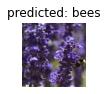

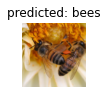

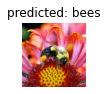

In [ ]:
visualize_model(model_conv)

## model parameter check

In [27]:
total_params = sum(p.numel() for p in model_conv.parameters())
total_params

11177538

In [28]:
from torchsummary import summary

summary(model_conv, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

## Light and Fast model

In [ ]:
model_mobilev2 = torchvision.models.mobilenet_v2(pretrained=True)
for p, _ in model_mobilev2.named_parameters():
    print(p)

In [30]:
model_mobilev2.classifier[1]

Linear(in_features=1280, out_features=1000, bias=True)

In [33]:
total_params = sum(p.numel() for p in model_mobilev2.parameters())
total_params

3504872

In [35]:
model_mobilev2 = model_mobilev2.to(device)
summary(model_mobilev2, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

In [36]:
model_mobilev2 = torchvision.models.mobilenet_v2(pretrained=True)
for param in model_mobilev2.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_mobilev2.classifier[1].in_features
model_mobilev2.classifier[1] = nn.Linear(num_ftrs, 2)

model_mobilev2 = model_mobilev2.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_mobilev2 = optim.SGD(model_mobilev2.classifier[1].parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_mobilev2, step_size=7, gamma=0.1)

In [37]:
model_mobilev2 = train_model(model_mobilev2, criterion, optimizer_mobilev2, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
Learning Rate 0.001
----------
train Loss: 0.5952 Acc: 0.6475
val Loss: 0.1969 Acc: 0.9542

Epoch 1/24
Learning Rate 0.001
----------
train Loss: 0.3794 Acc: 0.8361
val Loss: 0.1511 Acc: 0.9477

Epoch 2/24
Learning Rate 0.001
----------
train Loss: 0.3851 Acc: 0.8238
val Loss: 0.1795 Acc: 0.9281

Epoch 3/24
Learning Rate 0.001
----------
train Loss: 0.4732 Acc: 0.7992
val Loss: 0.1382 Acc: 0.9477

Epoch 4/24
Learning Rate 0.001
----------
train Loss: 0.4461 Acc: 0.7869
val Loss: 0.1298 Acc: 0.9608

Epoch 5/24
Learning Rate 0.001
----------
train Loss: 0.4214 Acc: 0.8320
val Loss: 0.1692 Acc: 0.9216

Epoch 6/24
Learning Rate 0.001
----------
train Loss: 0.3696 Acc: 0.8238
val Loss: 0.1432 Acc: 0.9412

Epoch 7/24
Learning Rate 0.0001
----------
train Loss: 0.2928 Acc: 0.8770
val Loss: 0.1614 Acc: 0.9216

Epoch 8/24
Learning Rate 0.0001
----------
train Loss: 0.3358 Acc: 0.8566
val Loss: 0.2271 Acc: 0.8954

Epoch 9/24
Learning Rate 0.0001
----------
train Loss: 0.3050 Acc: 0.88